In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Data Generator

In [2]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, img_height=64, img_width=64, batch_size=64, shuffle=True):
        self.file_paths = file_paths
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        images = [self.load_and_preprocess_image(file) for file in batch_files]
        return np.array(images), np.array(images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_paths)

    def load_and_preprocess_image(self, path):
        img = tf.keras.preprocessing.image.load_img(path, target_size=(self.img_height, self.img_width))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img / 255.0

## Get all the file paths

In [3]:
data_dir = './images'
img_height, img_width = (64, 64)

file_paths = []
files = os.listdir(data_dir)
for file in files:
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_paths.append(os.path.join(data_dir, file))

batch_size = 32
train_generator = DataGenerator(file_paths, img_height=img_height, img_width=img_width, batch_size=batch_size)

## Some examples of the dataset

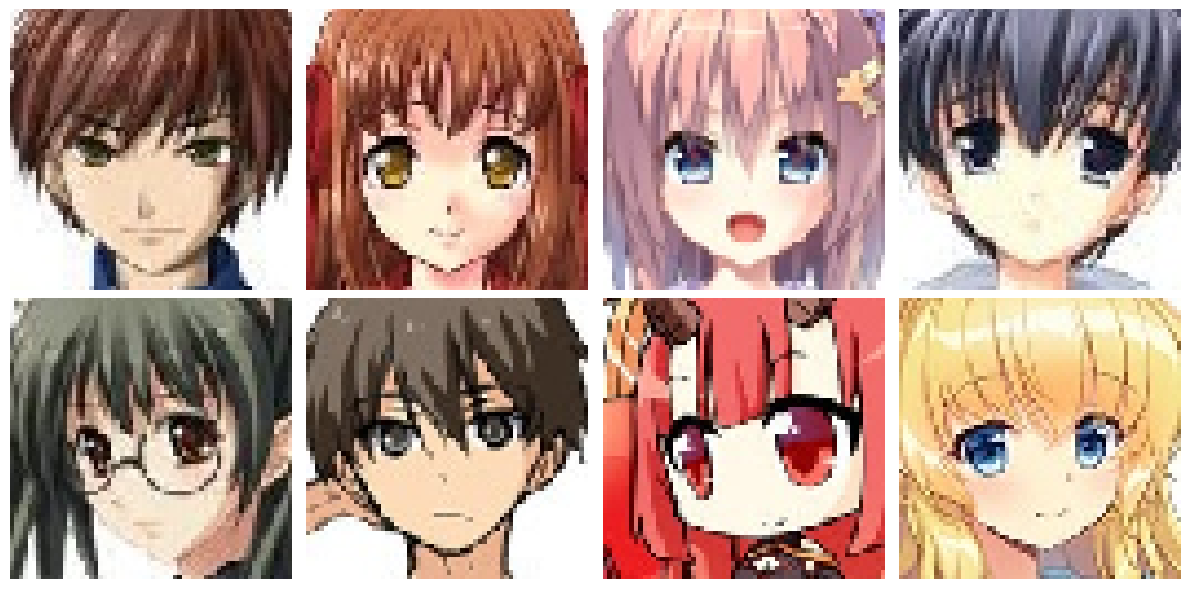

In [4]:
def show_random_images(generator, num_images=8):
    random_indices = np.random.randint(0, len(generator), size=num_images)
    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(random_indices):
        batch_images, _ = generator[idx]

        plt.subplot(2, 4, i + 1)
        plt.imshow(batch_images[0])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(train_generator, num_images=8)

# Model

In [7]:
embedding_dim = 64  # Dimension of the embedding vectors
num_embeddings = 512  # Number of embeddings in the codebook

## The class is used to handle the VectorQuantizer idea

In [8]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embeddings = self.add_weight(
            shape=(self.embedding_dim, self.num_embeddings),
            initializer="uniform",
            trainable=True,
            name="embeddings_vq"
        )
    
    def call(self, inputs):
        inputs_shape = tf.shape(inputs)
        flat_inputs = tf.reshape(inputs, [-1, self.embedding_dim])
        
        distances = (tf.reduce_sum(flat_inputs**2, axis=1, keepdims=True) 
                     - 2 * tf.matmul(flat_inputs, self.embeddings)
                     + tf.reduce_sum(self.embeddings**2, axis=0, keepdims=True))
        
        encoding_indices = tf.argmax(-distances, axis=1)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, inputs_shape)
        
        commitment_loss = 0.25 * tf.reduce_mean((tf.stop_gradient(quantized) - inputs)**2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(inputs))**2)
        
        quantized = inputs + tf.stop_gradient(quantized - inputs)
        
        return quantized, commitment_loss, codebook_loss, encodings

## Encoder part

In [9]:
encoder_inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))

x = tf.keras.layers.Conv2D(8, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = tf.keras.layers.Conv2D(16, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

encoder_outputs = tf.keras.layers.Conv2D(embedding_dim, 1, strides=1, padding='same')(x)
encoder = models.Model(encoder_inputs, encoder_outputs, name='encoder')

## Decoder part

In [10]:
decoder_inputs = tf.keras.layers.Input(shape=(4, 4, embedding_dim))

x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(decoder_inputs)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(16, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(8, 3, activation='relu', strides=2, padding='same')(x)

decoder_outputs = tf.keras.layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

## VQ-VAE model

In [11]:
class VQVAE(models.Model):
    def __init__(self, encoder, vector_quantizer, decoder, **kwargs):
        super(VQVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.vector_quantizer = vector_quantizer
        self.decoder = decoder
    
    def call(self, inputs):
        z_e = self.encoder(inputs)
        z_q, commitment_loss, codebook_loss, encodings = self.vector_quantizer(z_e)
        x_reconstructed = self.decoder(z_q)
        reconstruction_loss = tf.reduce_mean((inputs - x_reconstructed) ** 2)
        total_loss = reconstruction_loss + commitment_loss + codebook_loss
        self.add_loss(total_loss)
        return x_reconstructed
    
    def train_step(self, data):
        data = data[0]  # Get the images from the data
        with tf.GradientTape() as tape:
            z_e = self.encoder(data)
            z_q, commitment_loss, codebook_loss, encodings = self.vector_quantizer(z_e)
            reconstructed = self.decoder(z_q)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(tf.keras.layers.Flatten()(data), tf.keras.layers.Flatten()(reconstructed))))
            total_loss = reconstruction_loss + commitment_loss + codebook_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "commitment_loss": commitment_loss, "codebook_loss": codebook_loss}

In [12]:
vector_quantizer = VectorQuantizer(num_embeddings, embedding_dim)
vqvae = VQVAE(encoder, vector_quantizer, decoder)
vqvae.compile(optimizer='adam')

In [13]:
vqvae.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          4160      
                                                                 
Total params: 28688 (112.06 KB)
Trainable params: 28688 (11

In [14]:
vqvae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 4, 64)]        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 64)          36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 16)        4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 64, 64, 8)         1160      
 Transpose)                                                

In [15]:
history = vqvae.fit(train_generator, epochs=15)

Epoch 1/15
1986/1986 [==============================] - 111s 55ms/step - loss: 42.2888 - reconstruction_loss: 18.8509 - commitment_loss: 4.6876 - codebook_loss: 18.7503
Epoch 2/15
1986/1986 [==============================] - 131s 66ms/step - loss: 20.8389 - reconstruction_loss: 17.9650 - commitment_loss: 0.5748 - codebook_loss: 2.2991
Epoch 3/15
1986/1986 [==============================] - 114s 58ms/step - loss: 19.7674 - reconstruction_loss: 17.7432 - commitment_loss: 0.4048 - codebook_loss: 1.6193
Epoch 4/15
1986/1986 [==============================] - 111s 56ms/step - loss: 19.6171 - reconstruction_loss: 17.5964 - commitment_loss: 0.4041 - codebook_loss: 1.6166
Epoch 5/15
1986/1986 [==============================] - 115s 58ms/step - loss: 19.5738 - reconstruction_loss: 17.5301 - commitment_loss: 0.4088 - codebook_loss: 1.6350
Epoch 6/15
1986/1986 [==============================] - 114s 58ms/step - loss: 19.5792 - reconstruction_loss: 17.4919 - commitment_loss: 0.4175 - codebook_loss

# Results

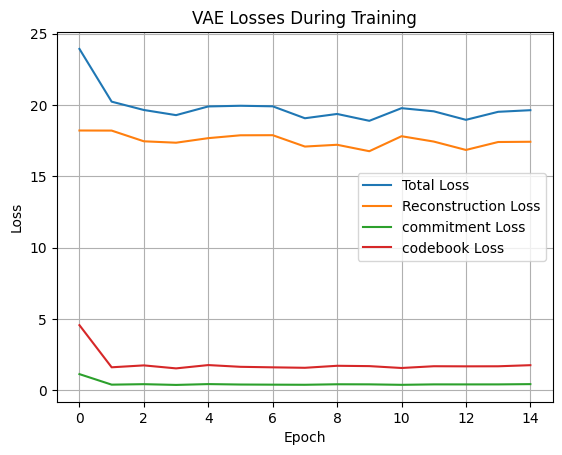

In [16]:
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['commitment_loss'], label='commitment Loss')
plt.plot(history.history['codebook_loss'], label='codebook Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Losses During Training')
plt.legend()
plt.grid(True)
plt.show()

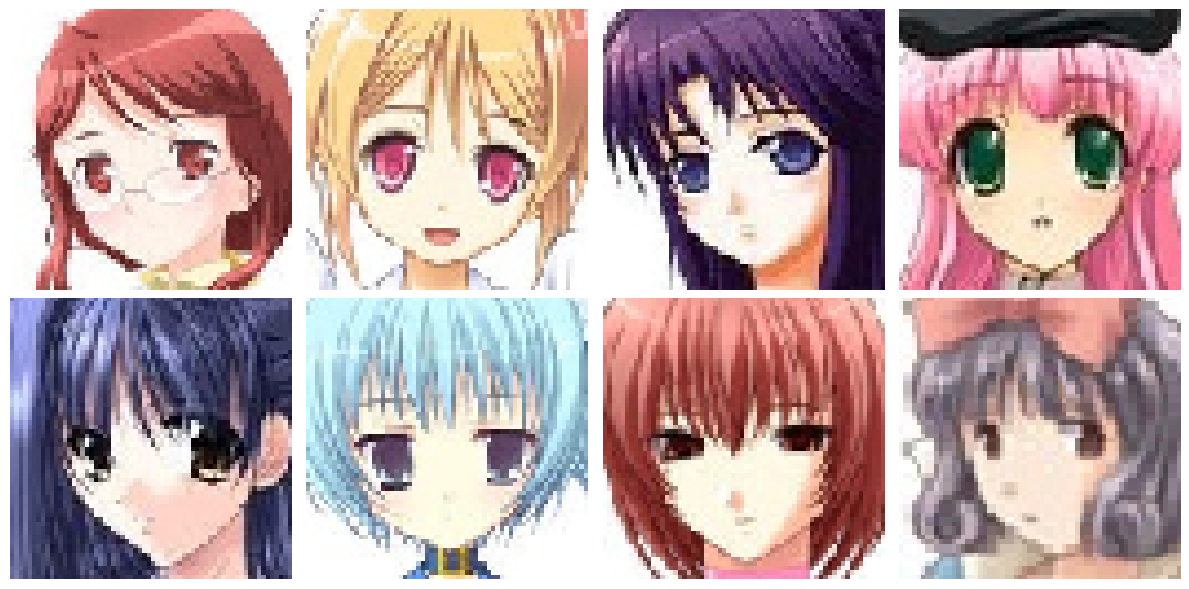

1/1 [==============================] - 0s 42ms/step


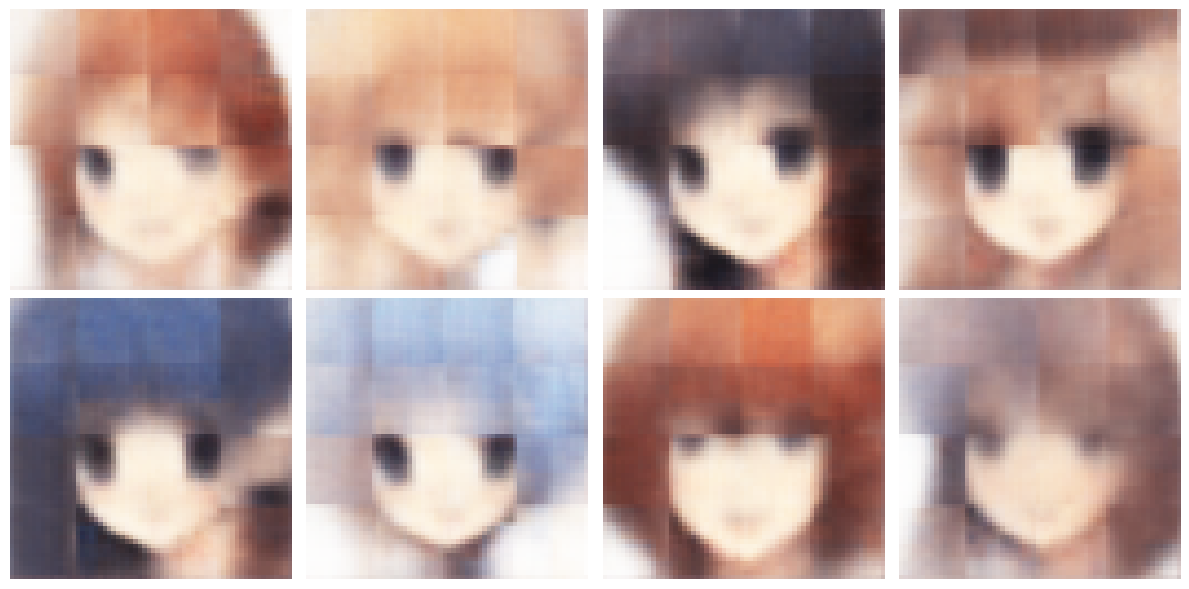

In [33]:
def show_predicted_images(generator, num_images=8):
    batch_images, _ = generator[np.random.randint(0, len(generator))]
    
    plt.figure(figsize=(12, 6))

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(batch_images[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    predicted = vqvae.predict(batch_images)
    
    plt.figure(figsize=(12, 6))

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(predicted[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predicted_images(train_generator, num_images=8)

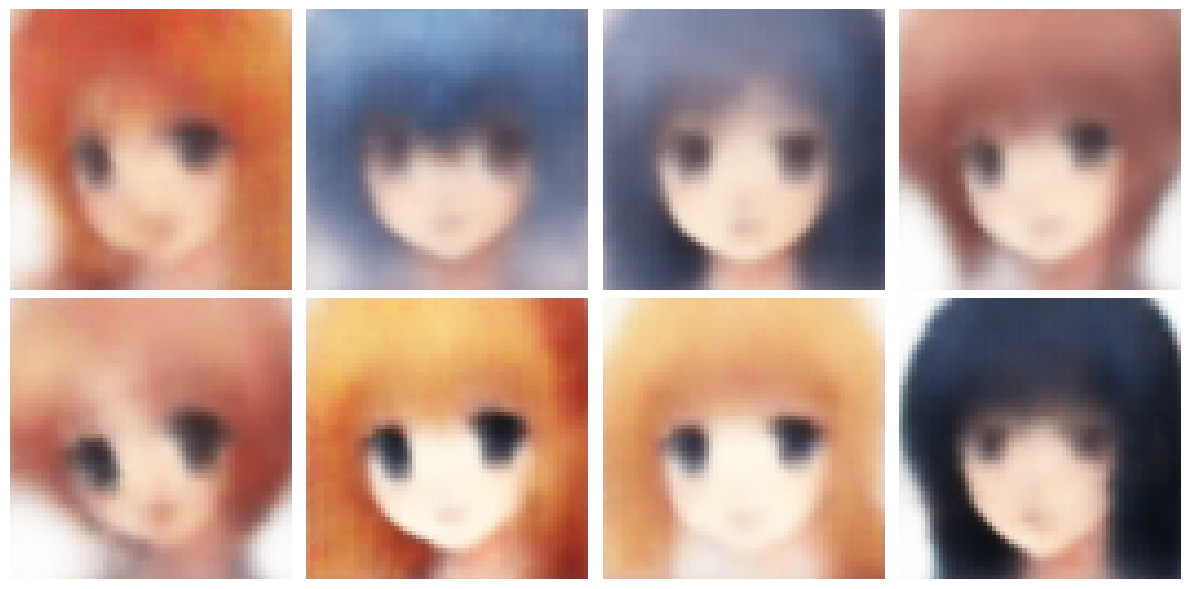

(32, 64, 64, 3)
1/1 [==============================] - 0s 40ms/step


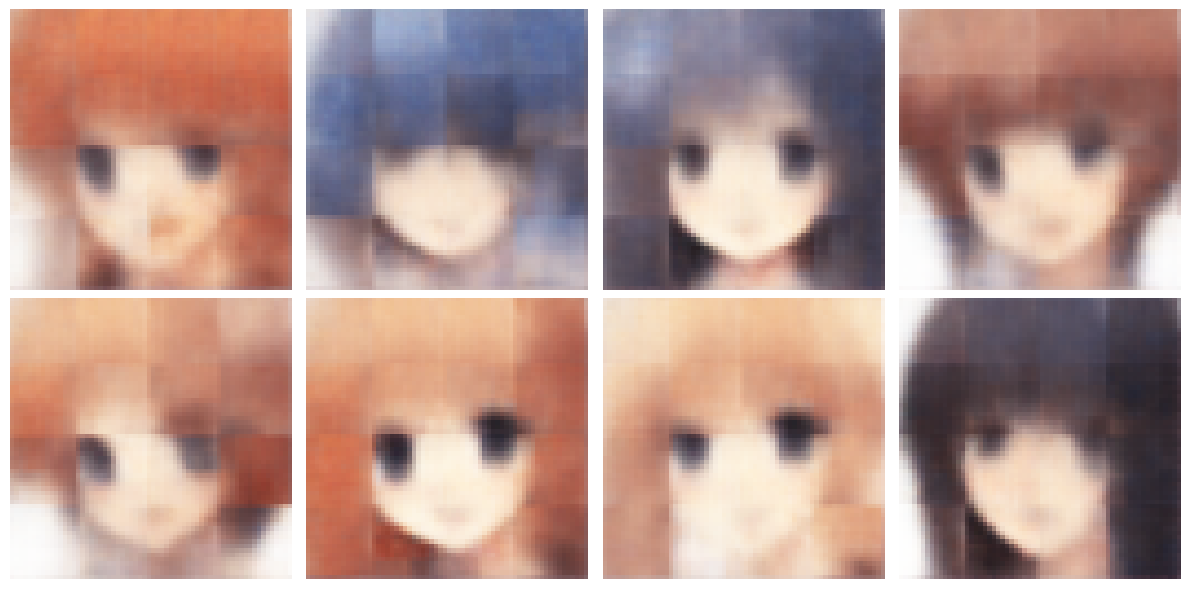

In [21]:
def load_and_preprocess_image(path, img_height=64, img_width=64):
        img = tf.keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img / 255.0
    
def show_saved_images(data_dir):
    file_paths = []
    files = os.listdir(data_dir)
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_paths.append(os.path.join(data_dir, file))
            
    images = [load_and_preprocess_image(file) for file in file_paths]
    
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    images = np.array(images*4)
    print(images.shape)
    
    predicted = vqvae.predict(images)
    plt.figure(figsize=(12, 6))

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(predicted[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_saved_images('./anime_generated')